# Identificación de un modelo OE utilizando PEM

A partir de un modelo expresado en la forma OE:

$$ y_k = \frac{B(q^{-1})}{A(q^{-1})} u_k + e_{k+1}$$

se plante la estimación de los parámetros que minimizan el error de predicción $\epsilon_k=y_k-\hat{y}_k$, donde la predicción se calcula como 
$$ \hat{y}_k = \frac{\hat{B}(q^{-1})}{\hat{A}(q^{-1})} u_k  $$
es decir que queda expresada en función de la entrada y de las predicciones pasadas. Esto conduce a que no pueda llevarse a la forma lineal en los parámtros que da sustento al planteo de mínimos cuadrados.

En el ejemplo se considera un sistema de primer orden, por lo que el predictor a 1 paso resulta:

$$ \hat{y}_{k+1} = \hat{a} \hat{y}_k + \hat{b} u_k$$

Al observar que el término $\hat{y}_k$ depende a su vez de $\hat{a}$ y $\hat{b}$, queda de manifiesto que los parámetros se multiplican entre sí y por lo tanto no se puede establecer un modelo lineal en los parámetros.


Definiendo el funcional 
$$J = \frac{1}{2} \sum_{k=1}^N \epsilon^\top \epsilon $$

Se puede buscar el set de parámetros que lo minimizan.

Consideremos el incremento del error de estimación en $k$ cuando se considera una variación $\Delta \theta$ en los parámetros.

$$\epsilon(k,\theta+ \Delta \theta) \sim \epsilon(k,\theta) - \left(\frac{\partial \hat{y} (k,\theta)}{\partial \theta}\right)^\top \Delta \theta$$

Definiendo el vector de sensibilidades 
$$ \varphi_k = \frac{\partial \hat{y} (k,\theta)}{\partial \theta} $$

y reemplazando la expresión del error de predicción, el funcional a minimizar resulta:

$$ J(\theta + \Delta \theta) \sim \frac{1}{2} \sum_{k=1}^N  \left(\epsilon(k,\theta)-\varphi_k^\top \Delta \theta \right)^2$$

Así nos queda una forma lineal del regresor en las variaciones de los parámetros, y el problema a resolver es idéntico al visto en mínimos cuadrados.

Continuando con el ejemplo del sistema de primer orden, el vector de sensibilidades se puede calcular también en forma recursiva:

$$ \frac{\partial \hat{y}_k}{\partial a} = s_a(k) = \hat{y}_{k-1} + a s_a(k-1) $$
$$ \frac{\partial \hat{y}_k}{\partial b} = s_b(k) = u_{k-1} + b s_b(k-1) $$

Luego queda armar los regresores y aplicar el algortimo de mínimos cuadrados recursivo.


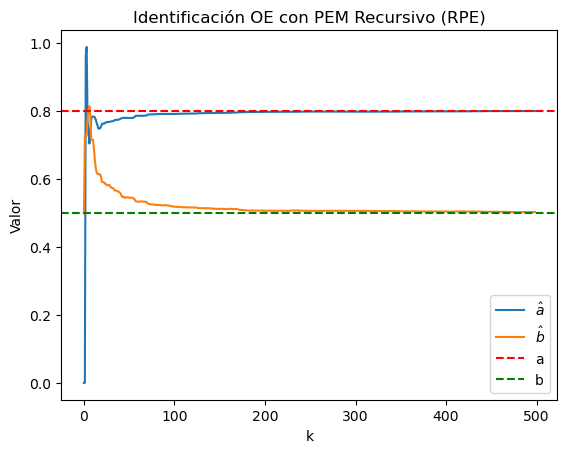

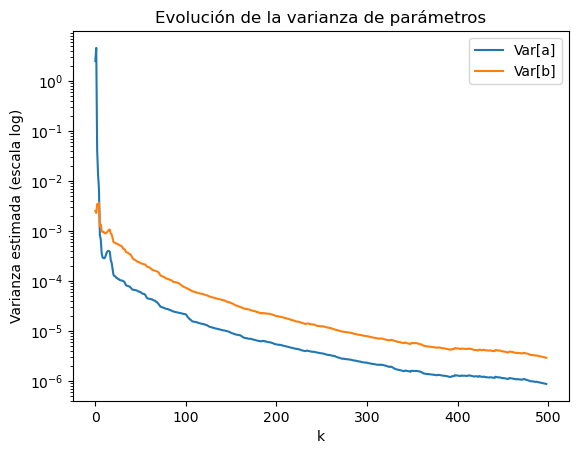

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# parámetros del sistema "real"
a, b = 0.8, 0.5

# parámetros de la simulación
N = 500
#u = np.random.choice([-1, 1], size=N)  # PRBS simple
np.random.seed(0)   # para reproducibilidad
u = np.sign(np.random.randn(N))  # entrada PRBS
e = 0.05 * np.random.randn(N)

# Simulación del sistema "real"
y_sr = np.zeros(N)
for k in range(1, N): 
    y_sr[k] = a * y_sr[k-1] + b * u[k-1]
# Sumo el ruido a la salida
y = y_sr + e

# Identificación OE con PEM recursivo (RPE)
theta = np.array([0.0, 0.0])  # [a, b] inicial
P = np.eye(2) * 1000.0        # covarianza inicial

# Para simular predictor y sensibilidades (jacobiano del error de predicción)
y_hat_prev = 0.0
s_a_prev, s_b_prev = 0.0, 0.0
sigma2_hat = 0.0

lambda_f = 1.0  # factor de olvido
lambda_sigma = 0.99  # para estimar varianza del ruido (recursivamente a partir de residuos)

theta_hist = []
P_hist = []
sigma2_hist = []

for k in range(1, N):
    # Predicción un paso adelante
    y_hat = theta[0] * y_hat_prev + theta[1] * u[k-1]

    # Error de predicción
    eps = y[k] - y_hat

    # Cálculo de sensibilidades (recursivas)
    s_a = y_hat_prev + theta[0] * s_a_prev
    s_b = u[k-1] + theta[0] * s_b_prev

    # Escribo el vector regresor con las sensibilidades. De esta forma el costo es lineal en theta
    phi = np.array([s_a, s_b])

    # Fromulas de actualización de mínimos cuadrados recursivos
    denom = 1.0 + phi @ P @ phi
    K = (P @ phi) / denom
    theta = theta + K * eps

    P = (1/lambda_f) * (np.eye(2) - np.outer(K, phi)) @ P

    # update estados para próxima iteración
    y_hat_prev = y_hat
    s_a_prev, s_b_prev = s_a, s_b

    # Estimación recursiva de varianza del ruido
    sigma2_hat = lambda_sigma * sigma2_hat + (1 - lambda_sigma) * (eps**2)
    sigma2_hist.append(sigma2_hat)

    # guardar historial
    theta_hist.append(theta.copy())
    P_hist.append(np.diag(P).copy())


theta_hist = np.array(theta_hist)
P_hist = np.array(P_hist)
sigma2_hist = np.array(sigma2_hist)

# varianzas reales theta_hat estimadas de: sigma2_hat * diag(P)
var_a = sigma2_hist * P_hist[:,0]
var_b = sigma2_hist * P_hist[:,1]


plt.figure()
plt.plot(theta_hist[:,0], label='$\\hat{{a}}$')
plt.plot(theta_hist[:,1], label='$\\hat{{b}}$')
plt.axhline(a, color='r', linestyle='--', label='a')
plt.axhline(b, color='g', linestyle='--', label='b')
plt.legend()
plt.xlabel('k')
plt.ylabel('Valor')
plt.title('Identificación OE con PEM Recursivo (RPE)')
plt.show()

plt.figure()
plt.semilogy(var_a, label='Var[a]')
plt.semilogy(var_b, label='Var[b]')
plt.xlabel('k')
plt.ylabel('Varianza estimada (escala log)')
plt.legend()
plt.title('Evolución de la varianza de parámetros')
plt.show()